# Import

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image  
import json
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os 
from torch.autograd import Variable
from torch.autograd import Function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


directory = "testing_data"
parent_dir = "./"
path = os.path.join(parent_dir, directory) 

if not os.path.isdir(path):
    os.mkdir(path) 

cuda


# Random seed

In [19]:
myseed = 724 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Read Json file and convert to JPEG image.


In [20]:
test_images = []
with open('60_data.json', 'r') as f:
    data = json.load(f) 

data = np.array(data)
data = (data-np.min(data))/(np.max(data)-np.min(data))
data = data.tolist()
for i in range (len(data)):
    data[i] = np.reshape(data[i], (28, 28))
    test_images.append(data[i])

test_imgs = copy.deepcopy(test_images)
test_imgs = np.array(test_imgs)
test_imgs = 255 * (test_imgs-np.min(test_imgs))/(np.max(test_imgs)-np.min(test_imgs))
for i in range(test_imgs.shape[0]):
    image = Image.fromarray(test_imgs[i])
    if image.mode == 'F':
        image = image.convert('L')
    image.save(f'./testing_data/{i}.jpg')
  
f.close()

test_images = np.array(list(test_images)).astype(np.float32)

# Custom Dataset

In [21]:
class CustomDataset(Dataset):
    
    def __init__(self, x, y, transform):
        self.transform = transform
        self.images = x
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.transform is not None:
            image = self.transform(self.images[index])
        return image, self.labels[index]

# Dataloader

In [22]:
train_tfm = transforms.Compose([transforms.ToTensor()])
mnist_training_dataset = datasets.MNIST(root='./data',
                                train=True,
                                download=True,
                                transform=train_tfm)



test_tfm = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
])
# test_loader = DataLoader(
#     datasets.MNIST(
#         "./data",
#         train=False,
#         download=True,
#         transform = test_tfm,
#     ),
#     batch_size=1,
#     shuffle=True,
# )

train_dataloader = DataLoader(mnist_training_dataset, batch_size=128, shuffle=True)

ground_truth = [0, 6, 4, 4, 5, 7, 3, 7]
test_dataset = CustomDataset(test_images ,ground_truth , test_tfm)
# print(len(test_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Neural Network

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.avgpooling1 = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.avgpooling2 = nn.AvgPool2d(2,2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpooling1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.avgpooling2(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

    # def __init__(self):
    #     super(Net, self).__init__()
    #     self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    #     self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    #     self.conv2_drop = nn.Dropout2d()
    #     self.fc1 = nn.Linear(320, 50)
    #     self.fc2 = nn.Linear(50, 10)

    # def forward(self, x):
    #     x = F.relu(F.max_pool2d(self.conv1(x), 2))
    #     x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    #     x = x.view(-1, 320)
    #     x = F.relu(self.fc1(x))
    #     x = F.dropout(x, training=self.training)
    #     x = self.fc2(x)
    #     return F.log_softmax(x, dim=1)

# Load Pretrain Model

In [24]:
model = Net().to(device)
model.load_state_dict(torch.load("mnist_model.pth", map_location="cpu"))
model.eval()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (avgpooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (avgpooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Train

In [25]:
epochs = 10
learning_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

def criterion(pred, label):
    return F.cross_entropy(pred, label)
    # return F.nll_loss(pred, label)

def train(model, device, train_loader, num_epoch):
    model.train()

    for epoch in range(num_epoch):
        
        train_loss = []
        train_accs = []

        for batch in tqdm(train_loader):
            data, labels = batch
            data, labels = data.to(device), labels.to(device)
            
            output_logits = model(data)
            loss = criterion(output_logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output_logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        print(f"[ Train | {epoch + 1:03d}/{num_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
        
    torch.save(model.state_dict(), "mnist_model_revise.pth")

# Test

In [26]:
def test(model, device, test_loader):
    model.eval()

    test_accs = []
    for batch in tqdm(test_loader):

        imgs, labels = batch
        with torch.no_grad():
            output_logits = model(imgs.to(device))
        
        acc = (output_logits.argmax(dim=-1) == labels.to(device)).float().mean()
        test_accs.append(acc)

        # Take the class with greatest logit as prediction and record it.
        # pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
        prediction = output_logits.argmax(dim=-1)
        
        imgs = imgs.squeeze().detach().cpu().numpy() 

    train_acc = sum(test_accs) / len(test_accs)
    print(f"[ Test ] acc = {train_acc:.5f}")

# Run 

In [27]:
# train(model, device, train_dataloader, epochs)
test(model, device, test_dataloader)

100%|██████████| 469/469 [00:05<00:00, 79.48it/s]


[ Train | 001/010 ] loss = 0.12130, acc = 0.97392


100%|██████████| 469/469 [00:05<00:00, 81.15it/s]


[ Train | 002/010 ] loss = 0.06822, acc = 0.97976


100%|██████████| 469/469 [00:05<00:00, 81.65it/s]


[ Train | 003/010 ] loss = 0.05635, acc = 0.98323


100%|██████████| 469/469 [00:05<00:00, 81.66it/s]


[ Train | 004/010 ] loss = 0.04879, acc = 0.98534


100%|██████████| 469/469 [00:05<00:00, 82.61it/s]


[ Train | 005/010 ] loss = 0.04359, acc = 0.98692


100%|██████████| 469/469 [00:05<00:00, 82.77it/s]


[ Train | 006/010 ] loss = 0.03884, acc = 0.98814


100%|██████████| 469/469 [00:05<00:00, 80.72it/s]


[ Train | 007/010 ] loss = 0.03581, acc = 0.98932


100%|██████████| 469/469 [00:05<00:00, 81.26it/s]


[ Train | 008/010 ] loss = 0.03284, acc = 0.98987


100%|██████████| 469/469 [00:05<00:00, 81.78it/s]


[ Train | 009/010 ] loss = 0.03029, acc = 0.99088


100%|██████████| 469/469 [00:05<00:00, 82.92it/s]


[ Train | 010/010 ] loss = 0.02852, acc = 0.99150


100%|██████████| 8/8 [00:00<00:00, 1709.08it/s]

[ Test ] acc = 1.00000


# GuidedBackprop ＆ Modify ReLU

In [28]:
# 定義GuidedBackpropReLU函數
class GuidedBackpropReLU_1(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        grad_input[input >= 0] = 1
        return grad_input * grad_output


# 修改模型中的ReLU層
def modify_ReLU_1(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(lambda module, input, output: GuidedBackpropReLU_1.apply(output))
        else:
            modify_ReLU_1(module)


class GuidedBackpropReLU_2(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
    
# 修改模型中的ReLU層
def modify_ReLU_2(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(lambda module, input, output: GuidedBackpropReLU_2.apply(output))
        else:
            modify_ReLU_2(module)


# GradCam


In [29]:
class GuidedGradCam():
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        self.hook_feature()
        self.hook_gradient()

    def hook_feature(self):
        def hook_fn(module, input, output):
            self.feature_maps = output

        self.target_layer.register_forward_hook(hook_fn)

    def hook_gradient(self):
        def hook_fn(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_backward_hook(hook_fn)

    def normalize_cam(self,x):
        x = 2*( x - torch.min(x)) / (torch.max(x) - torch.min(x) + 1e-8 ) - 1
        # x[x<torch.max(x)]=-1
        return x
    
    def forward(self, x):
        return self.model(x)

    def backward(self, output, target_class):
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[:, target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

    def generate_guided_gradcam(self):
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        cam = self.normalize_cam(cam)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(28, 28), mode='bilinear', align_corners=False)
        # cam = cam.squeeze(1)
        cam = cam.squeeze().detach().cpu().numpy() 
        cam = (cam - 0) / (cam.max())
        
        return cam


# Run

/home/lambo/anaconda3/envs/Pytorch/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/tmp/ipykernel_3385605/50930986.py:45: RuntimeWarning: invalid value encountered in divide
  cam = (cam - 0) / (cam.max())


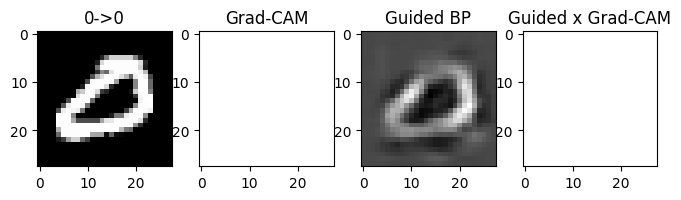

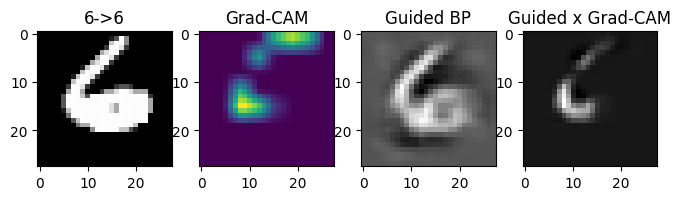

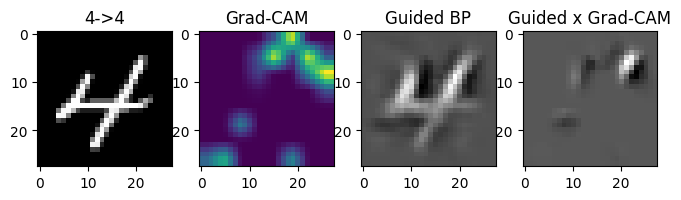

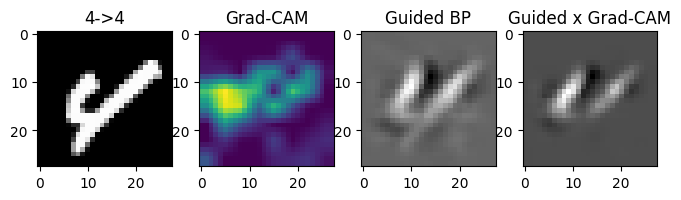

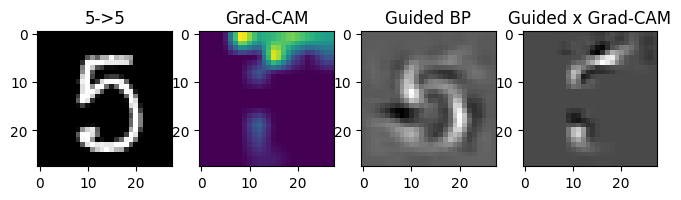

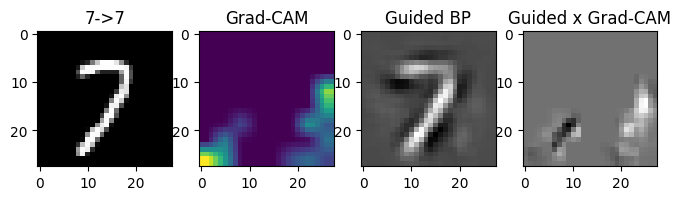

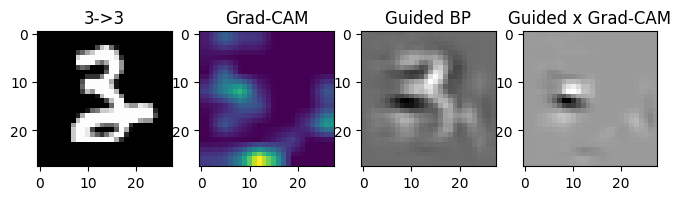

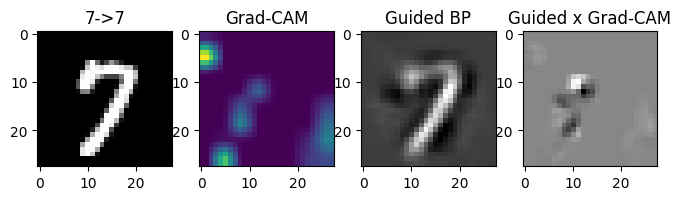

In [30]:
original_model = Net()
original_model.load_state_dict(torch.load("./mnist_model.pth", map_location="cpu")) 
original_model.eval()


Guided_backprop_model = Net()
Guided_backprop_model.load_state_dict(torch.load("./mnist_model.pth", map_location="cpu")) 
Guided_backprop_model.eval()
modify_ReLU_2(Guided_backprop_model)


GuidedGradCam_model = Net()
GuidedGradCam_model.load_state_dict(torch.load("./mnist_model.pth", map_location="cpu")) 
GuidedGradCam_model.eval()
modify_ReLU_1(GuidedGradCam_model) 

target_layer = GuidedGradCam_model.relu2
guided_gradcam = GuidedGradCam(GuidedGradCam_model, target_layer)
# guided_gradcam = GuidedGradCam(original_model, target_layer)



for index, batch in enumerate(test_dataloader):

    image, label = batch

    # generate Guided_backprop image
    image.requires_grad_()
    output = Guided_backprop_model(image)
    guided_backprop = torch.autograd.grad(output[0, label], image)[0]
    guided_backprop_image = guided_backprop[0, 0].squeeze().detach().cpu().numpy() 

    # generate guided_gradcam image
    output = guided_gradcam.forward(image)
    target_class = label
    guided_gradcam.backward(output, target_class)
    guided_gradcam_image = guided_gradcam.generate_guided_gradcam()
    

    with torch.no_grad():
        output_logits = model(image.to(device))
    prediction = output_logits.argmax(dim=-1)


    image = image.squeeze().detach().cpu().numpy() 
    label = label.squeeze().detach().cpu().numpy() 
    prediction = prediction.squeeze().detach().cpu().numpy() 
    # 可視化
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 4, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'{label}->{prediction}')

    plt.subplot(1, 4, 2)
    plt.imshow(guided_gradcam_image, alpha=1)
    plt.title(f'Grad-CAM')

    plt.subplot(1, 4, 3)
    plt.imshow(guided_backprop_image, cmap='gray')
    plt.title(f'Guided BP')


    plt.subplot(1, 4, 4)
    plt.imshow(guided_gradcam_image*guided_backprop_image, alpha=1, cmap='gray')
    plt.title(f'Guided x Grad-CAM')

    plt.show()

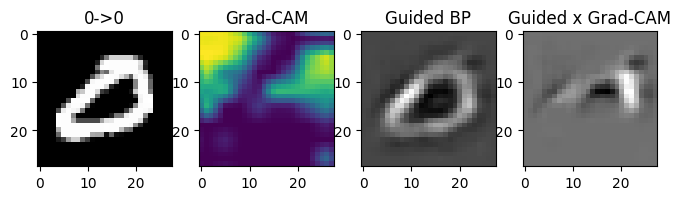

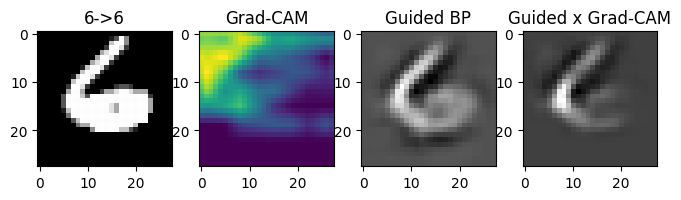

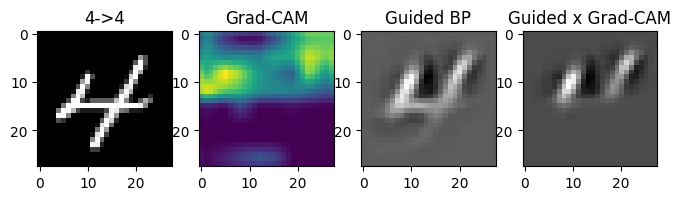

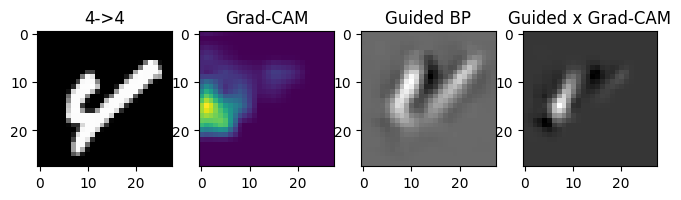

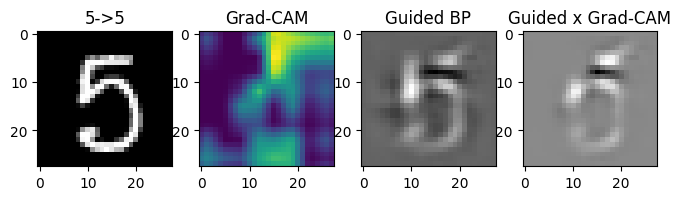

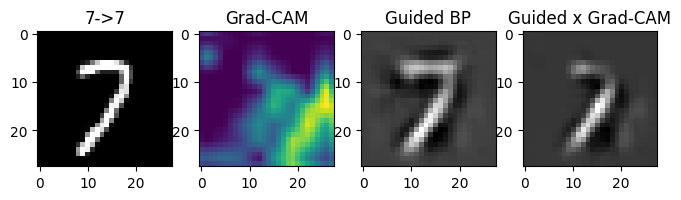

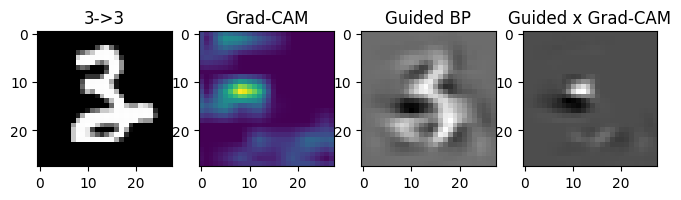

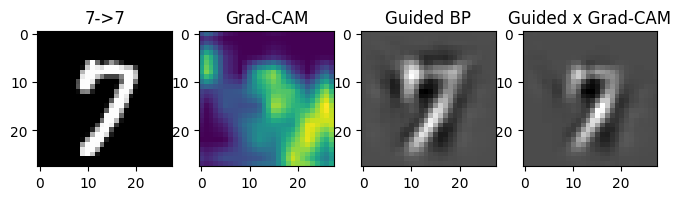

In [31]:
# from skimage.transform import resize
# # 欲修改的Relu
# class GuidedBackpropReLU_2(Function):
#     @staticmethod
#     def forward(ctx,input):
#         ctx.save_for_backward(input)
#         return input.clamp(min=0)
    
#     @staticmethod
#     def backward(ctx,grad_output):
#         input = ctx.saved_tensors[0]
#         grad_input = grad_output.clone()
#         grad_input[grad_input<0] = 0
#         grad_input[input<0]=0
#         return grad_input
    
# # 修改模型中的ReLU層
# def modify_ReLU_2(model):
#     for name, module in model.named_children():
#         if isinstance(module, nn.ReLU):
#             module.register_forward_hook(lambda module, input, output: GuidedBackpropReLU_2.apply(output))
#         else:
#             modify_ReLU_2(module)

# # 抓feature map
# def forward_hook(module, input, output):
#     activation.append(output)
# # 抓gradient
# def backward_hook(module, grad_in, grad_out):
#     grad.append(grad_out[0])
# # ?
# def normalize_cam(x): 
#     x = 2 * ( x - torch.min(x)) / (torch.max(x) - torch.min(x) + 1e-8 ) - 1
#     # x[x<torch.max(x)]=-1
#     return x



# original_model = Net()
# original_model.load_state_dict(torch.load("./mnist_model_revise.pth")) 
# original_model.eval()

# Guided_backprop_model = Net()
# Guided_backprop_model.load_state_dict(torch.load("./mnist_model_revise.pth"))
# Guided_backprop_model.eval()
# modify_ReLU_2(Guided_backprop_model)


# #   Add hook to get the tensors
# original_model.relu2.register_forward_hook(forward_hook)
# original_model.relu2.register_backward_hook(backward_hook)

# grad=[]
# activation=[]

# for index, batch in enumerate(test_dataloader):

#     image, label = batch
    
#     # generate Guided_backprop image
#     image.requires_grad_()
#     output = Guided_backprop_model(image)
#     guided_backprop = torch.autograd.grad(output[0, label], image)[0]
#     guided_backprop_image = guided_backprop[0, 0].squeeze().detach().cpu().numpy() 


#     # generate Grad-Cam
#     out = original_model(image)
#     loss=out[0, label]
#     original_model.zero_grad()
#     loss.backward()

#     grads = grad[index].cpu().data.numpy().squeeze()
#     fmap = activation[index].cpu().data.numpy().squeeze()

#     tmp = grads.reshape([grads.shape[0],-1])
#     weights = np.mean(tmp, axis=1)

#     cam = np.zeros(grads.shape[1:])
#     for i,w in enumerate(weights):
#         cam += w*fmap[i,:]
	
#     cam = normalize_cam(torch.tensor(cam))
#     cam = cam.cpu().data.numpy()
#     cam = (cam > 0) * cam
#     cam = cam / 255
#     cam = resize(cam, output_shape=(28,28))


#     with torch.no_grad():
#         output_logits = model(image.to(device))
#     prediction = output_logits.argmax(dim=-1)


#     image = image.squeeze().detach().cpu().numpy() 
#     label = label.squeeze().detach().cpu().numpy()
#     prediction = prediction.squeeze().detach().cpu().numpy() 

#     plt.figure(figsize=(8, 2))

#     plt.subplot(1, 4, 1)
#     plt.imshow(image, cmap='gray')
#     plt.title(f'{label}->{prediction}')

#     plt.subplot(1, 4, 2)
#     plt.imshow(cam, alpha=1)
#     plt.title(f'Grad-CAM')

#     plt.subplot(1, 4, 3)
#     plt.imshow(guided_backprop_image, cmap='gray')
#     plt.title(f'Guided BP')

#     plt.subplot(1, 4, 4)
#     plt.imshow(cam*guided_backprop_image, alpha=1, cmap='gray')
#     plt.title(f'Guided x Grad-CAM')

#     plt.show()